In [25]:
import requests
from bs4 import BeautifulSoup
import numpy as np
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import sent_tokenize, word_tokenize
import matplotlib.pyplot as plt
import nltk
import re

## Step 1: Ambil Artikel dan Preprosessing Artikel

In [28]:
url = 'https://id.wikipedia.org/wiki/Kecerdasan_buatan'

response = requests.get(url)
html_content = response.text

soup = BeautifulSoup(html_content, 'html.parser')
paragraphs = soup.find_all('p')

# Gabungkan semua paragraf menjadi satu teks
article_text = ''
for paragraph in paragraphs:
    article_text += paragraph.text + '\n'

print(article_text)


Kecerdasan buatan atau akal imitasi (bahasa Inggris: artificial intelligence, AI) adalah kecerdasan yang ditambahkan kepada suatu sistem yang bisa diatur dalam konteks ilmiah, AI juga didefinisikan sebagai kecerdasan entitas ilmiah. Andreas Kaplan dan Michael Haenlein mendefinisikan kecerdasan buatan sebagai “kemampuan sistem untuk menafsirkan data eksternal dengan benar, untuk belajar dari data tersebut, dan menggunakan pembelajaran tersebut guna mencapai tujuan dan tugas tertentu melalui adaptasi yang fleksibel”.[1] Sistem seperti ini umumnya dianggap komputer. Kecerdasan diciptakan dan dimasukkan ke dalam komputer agar dapat melakukan pekerjaan seperti yang dapat dilakukan manusia. Beberapa macam bidang yang menggunakan kecerdasan buatan antara lain sistem pakar, permainan komputer, logika kabur, jaringan saraf tiruan dan robotika. Secara teknis, kecerdasan buatan adalah model statistik yang digunakan untuk mengambil keputusan dengan menggeneralisir karakteristik dari suatu objek be

In [29]:
article_text = article_text.lower()

In [30]:
teks_prep = re.sub(r'\[\d+\]', '', article_text)  # Hilangkan referensi [1], [2], dll.

In [31]:
teks_prep1 = re.sub(r'\s+', ' ', teks_prep)     # Hilangkan spasi berlebih

In [32]:
clean_teks = re.sub(r'\([^)]*\)', '', teks_prep1)  # Hilangkan teks dalam tanda kurung
print(clean_teks)

kecerdasan buatan atau akal imitasi  adalah kecerdasan yang ditambahkan kepada suatu sistem yang bisa diatur dalam konteks ilmiah, ai juga didefinisikan sebagai kecerdasan entitas ilmiah. andreas kaplan dan michael haenlein mendefinisikan kecerdasan buatan sebagai “kemampuan sistem untuk menafsirkan data eksternal dengan benar, untuk belajar dari data tersebut, dan menggunakan pembelajaran tersebut guna mencapai tujuan dan tugas tertentu melalui adaptasi yang fleksibel”. sistem seperti ini umumnya dianggap komputer. kecerdasan diciptakan dan dimasukkan ke dalam komputer agar dapat melakukan pekerjaan seperti yang dapat dilakukan manusia. beberapa macam bidang yang menggunakan kecerdasan buatan antara lain sistem pakar, permainan komputer, logika kabur, jaringan saraf tiruan dan robotika. secara teknis, kecerdasan buatan adalah model statistik yang digunakan untuk mengambil keputusan dengan menggeneralisir karakteristik dari suatu objek berbasis data yang kemudian dipasang di berbagai p

## Step 2: Latih Model Word2Vec
### Tokenisasi teks menjadi kalimat, lalu setiap kalimat menjadi kata

In [34]:
sentences = [word_tokenize(sentence.lower()) for sentence in sent_tokenize(clean_teks)]
sentences

[['kecerdasan',
  'buatan',
  'atau',
  'akal',
  'imitasi',
  'adalah',
  'kecerdasan',
  'yang',
  'ditambahkan',
  'kepada',
  'suatu',
  'sistem',
  'yang',
  'bisa',
  'diatur',
  'dalam',
  'konteks',
  'ilmiah',
  ',',
  'ai',
  'juga',
  'didefinisikan',
  'sebagai',
  'kecerdasan',
  'entitas',
  'ilmiah',
  '.'],
 ['andreas',
  'kaplan',
  'dan',
  'michael',
  'haenlein',
  'mendefinisikan',
  'kecerdasan',
  'buatan',
  'sebagai',
  '“',
  'kemampuan',
  'sistem',
  'untuk',
  'menafsirkan',
  'data',
  'eksternal',
  'dengan',
  'benar',
  ',',
  'untuk',
  'belajar',
  'dari',
  'data',
  'tersebut',
  ',',
  'dan',
  'menggunakan',
  'pembelajaran',
  'tersebut',
  'guna',
  'mencapai',
  'tujuan',
  'dan',
  'tugas',
  'tertentu',
  'melalui',
  'adaptasi',
  'yang',
  'fleksibel',
  '”',
  '.'],
 ['sistem', 'seperti', 'ini', 'umumnya', 'dianggap', 'komputer', '.'],
 ['kecerdasan',
  'diciptakan',
  'dan',
  'dimasukkan',
  'ke',
  'dalam',
  'komputer',
  'agar',
  'da

In [35]:
# Latih Word2Vec
model = Word2Vec(sentences=sentences, vector_size=100, window=3, min_count=1, sg=1)

**Penjelasan :** 

**vector_size = 100** Menentukan dimensi atau ukuran dari vektor kata yang dihasilkan oleh Word2Vec. Setiap kata akan direpresentasikan sebagai vektor berukuran 100 dimensi.

**window = 3** Ukuran jendela konteks, yaitu jumlah kata tetangga di kiri dan kanan kata target yang dipertimbangkan oleh model. Dalam hal ini, kata dalam jarak 3 dari kata target akan digunakan untuk menentukan konteksnya.

**min_count = 1** Menentukan jumlah minimum kemunculan kata agar kata tersebut dipertimbangkan oleh model. min_count=1 berarti semua kata, bahkan yang muncul sekali, akan disertakan dalam pelatihan.

**sg=1** digunakan untuk mengatur algoritma pelatihan Word2Vec, di mana:
**sg=1 menggunakan Skip-gram**, yang mencoba memprediksi konteks dari kata target.
**sg=0 menggunakan CBOW (Continuous Bag of Words)**, yang mencoba memprediksi kata target dari konteks.

Word2Vec menghasilkan representasi vektor dari kata, yang memungkinkan kita menghitung kesamaan antar kata dan kalimat.

## Step 3: Fungsi untuk Meringkas Teks

In [38]:
def sentence_vector(sentence, model):
    words = [word for word in word_tokenize(sentence.lower()) if word in model.wv]
    if words:
        return np.mean(model.wv[words], axis=0)
    else:
        return np.zeros(model.vector_size)

def summarize_text(text, model, top_n=8):
    sentences = sent_tokenize(text)  # Tokenisasi kalimat
    sentence_vectors = [sentence_vector(sent, model) for sent in sentences]

    # Hitung skor kesamaan setiap kalimat dengan keseluruhan teks
    text_vector = np.mean(sentence_vectors, axis=0)
    similarities = [cosine_similarity([text_vector], [vec])[0][0] for vec in sentence_vectors]

    # Pilih top_n kalimat dengan skor kesamaan tertinggi
    ranked_sentences = [sent for _, sent in sorted(zip(similarities, sentences), reverse=True)]
    return ' '.join(ranked_sentences[:top_n])

## Step 4: Ringkas Artikel

In [40]:
# Hitung jumlah kalimat asli
original_sentences = sent_tokenize(article_text)
num_original_sentences = len(original_sentences)

# Ringkas artikel
summary = summarize_text(clean_teks, model, top_n=8)

# Hitung jumlah kalimat ringkasan
summary_sentences = sent_tokenize(summary)
num_summary_sentences = len(summary_sentences)

# Hitung persentase reduksi
reduction_percentage = (1 - (num_summary_sentences / num_original_sentences)) * 100

# Cetak hasil
print(f"\nJumlah Kalimat Asli: {num_original_sentences}")
print(f"Jumlah Kalimat Ringkasan: {num_summary_sentences}")
print(f"Persentase Reduksi: {reduction_percentage:.2f}%")

print("\nRingkasan Artikel:")
print(summary)



Jumlah Kalimat Asli: 57
Jumlah Kalimat Ringkasan: 8
Persentase Reduksi: 85.96%

Ringkasan Artikel:
walaupun ai memiliki konotasi fiksi ilmiah yang kuat, ai membentuk cabang yang sangat penting pada ilmu komputer, berhubungan dengan perilaku, pembelajaran dan adaptasi yang cerdas dalam sebuah mesin. sistem ai sekarang ini sering digunakan dalam bidang ekonomi, sains, obat-obatan, teknik dan militer, seperti yang telah dibangun dalam beberapa aplikasi perangkat lunak komputer rumah dan video gim. dalam fiksi sains, ai umumnya dilukiskan sebagai kekuatan masa depan yang akan mencoba menggulingkan otoritas manusia seperti dalam hal 9000, skynet, colossus and the matrix atau sebagai penyerupaan manusia untuk memberikan layanan seperti c-3po, data, the bicentennial man, the mechas dalam a.i. tantangan hebat darpa, yang dimulai pada 2004 dan berlanjut hingga hari ini, adalah sebuah pacuan untuk hadiah $2 juta di mana kendaraan dikemudikan sendiri tanpa komunikasi dengan manusia, menggunakan 

## Step 5: Evaluasi Model

In [51]:
# Langkah 1: Persiapkan teks (artikel asli dan ringkasan)
original_sentences = [word_tokenize(sent.lower()) for sent in sent_tokenize(article_text)]
summary_sentences = [word_tokenize(sent.lower()) for sent in sent_tokenize(summary)]

# Latih model Word2Vec menggunakan artikel asli
model = Word2Vec(original_sentences + summary_sentences, vector_size=100, window=3, min_count=1, sg=0)

# Langkah 2: Dapatkan vektor rata-rata untuk setiap teks
def get_mean_vector(text, model):
    vectors = [model.wv[word] for word in text if word in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

# Langkah 3: Hitung vektor rata-rata untuk artikel asli dan ringkasan
original_vector = get_mean_vector([word for sent in original_sentences for word in sent], model)
summary_vector = get_mean_vector([word for sent in summary_sentences for word in sent], model)

# Langkah 4: Hitung Cosine Similarity antara artikel asli dan ringkasan
cosine_sim = cosine_similarity([original_vector], [summary_vector])[0][0]

print(f"Kesamaan Semantik antara Artikel Asli dan Ringkasan: {cosine_sim:.4f}")

Kesamaan Semantik antara Artikel Asli dan Ringkasan: 0.9644


### 1. Cosine Similarity dalam Kesamaan Semantik
Cosine similarity digunakan untuk mengukur sudut kosinus antara dua vektor dalam ruang multidimensi.

- Nilai Cosine Similarity mendekati 1:
Ringkasan memiliki kesamaan semantik yang sangat baik dengan artikel asli.

- Nilai mendekati 0:
Ringkasan tidak merepresentasikan artikel dengan baik secara semantis.

- Nilai negatif:
Ringkasan memiliki makna yang berlawanan dengan artikel asli (jarang terjadi dalam kasus umum, tapi bisa jika ringkasan salah fokus).

### 2. Kesamaan Semantik di Model Word2Vec
Model Word2Vec bekerja dengan cara mempelajari representasi vektor kata-kata dari teks. Kata-kata yang sering muncul dalam konteks serupa memiliki vektor yang berdekatan dalam ruang vektor.
Kalimat yang maknanya mirip seharusnya memiliki skor cosine similarity yang tinggi karena kata-kata di dalamnya akan membentuk vektor dengan arah serupa.

### 3. Pengecekan Kualitas Kesamaan Semantik
Untuk memastikan bahwa hasil kesamaan semantik dari ringkasan dan teks asli baik, kamu bisa memeriksa beberapa hal:

- Evaluasi Manual:
Baca kalimat-kalimat yang dipilih oleh ringkasan dan cek apakah ringkasan tersebut menangkap inti dari artikel.
- Distribusi Skor Cosine Similarity:
Hitung skor cosine similarity setiap kalimat dengan keseluruhan teks dan tampilkan hasilnya. Ini membantu untuk memahami apakah kalimat dengan skor tertinggi benar-benar paling relevan secara semantik.

### 4. Interpretasi Skor
- Jika skor cosine similarity memiliki nilai rata-rata mendekati 1 atau tinggi, maka model berhasil menangkap kesamaan semantik dengan baik.
- Jika banyak skor yang rendah atau distribusi tidak merata, mungkin perlu dilakukan tuning model atau menambah jumlah data pelatihan agar Word2Vec lebih akurat.

In [55]:
# Pastikan teks ringkas sudah diproses dan dibagi per kalimat
sentences = [word_tokenize(sentence.lower()) for sentence in sent_tokenize(clean_teks)]

# Hitung vektor untuk setiap kalimat
sentence_vectors = [sentence_vector(' '.join(sentence), model) for sentence in sentences]

# Cek apakah sentence_vectors berisi data valid
print(f"Jumlah vektor kalimat: {len(original_sentences)}")
print(f"Contoh vektor pertama: {sentence_vectors[0]}")

Jumlah vektor kalimat: 57
Contoh vektor pertama: [-2.7073263e-03  4.2116418e-04  3.4774654e-04  1.6179150e-03
  1.8958735e-03 -2.7442749e-03 -7.6110061e-04  3.0718292e-03
 -2.7918303e-03 -6.0277595e-04 -1.3111350e-03 -1.7791451e-03
 -1.9628736e-03  6.9674500e-04  1.7286311e-03  2.9487308e-04
 -1.3889878e-03  1.0134862e-03 -2.8624495e-03 -3.1887288e-03
  2.0329722e-03  1.7642265e-03  3.3688238e-03 -1.3187506e-03
  4.6714742e-04  5.6469388e-04 -1.4384782e-03 -4.0838722e-04
 -1.9659754e-03  2.2506118e-03  2.5756736e-03 -2.4797069e-03
  2.0641224e-03 -5.4322794e-04 -1.0404532e-03  3.2872239e-03
  6.9913757e-04  1.4660518e-03 -5.2610738e-04 -5.9753383e-04
 -4.9249560e-04 -2.8274686e-03 -2.7825332e-03  6.9347472e-04
  2.3603677e-03 -7.9687242e-04 -1.3557022e-03 -1.6849258e-03
  1.4148608e-03  7.1745791e-04  6.2647683e-04 -3.5019839e-04
 -9.1601774e-04  9.3833230e-05  9.5890270e-04  9.6614583e-04
  1.4336107e-03 -6.4814079e-04 -1.6938060e-04  3.8555011e-04
 -4.4791677e-04 -1.7165408e-03  2.36

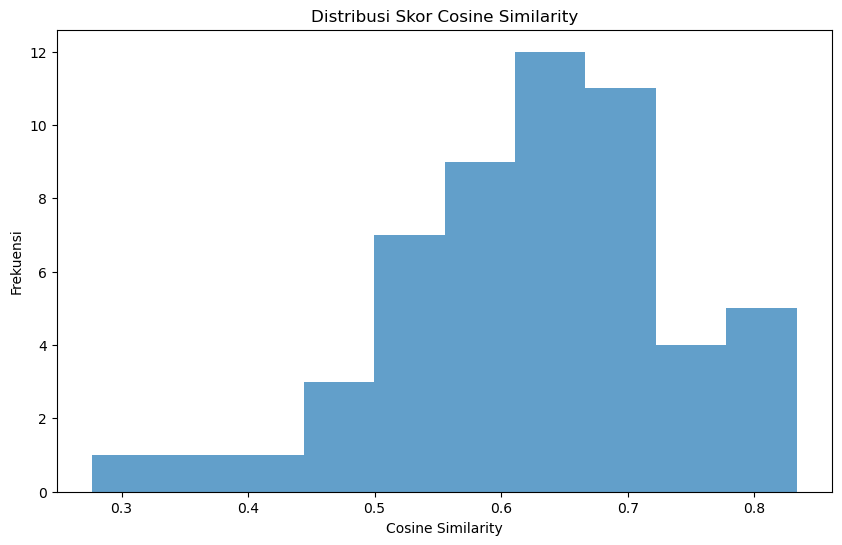

In [57]:
# Hitung rata-rata vektor teks
text_vector = np.mean(sentence_vectors, axis=0)

# Hitung skor kesamaan untuk setiap kalimat
similarities = [cosine_similarity([text_vector], [vec])[0][0] for vec in sentence_vectors]

# Tampilkan distribusi skor kesamaan
plt.figure(figsize=(10, 6))
plt.hist(similarities, bins=10, alpha=0.7)
plt.title('Distribusi Skor Cosine Similarity')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frekuensi')
plt.show()